In [1]:
#install PyPDF2 library
! pip install PyPDF2
#install nltk library
! pip install nltk==3.5
#install matplotlib library
! pip install numpy matplotlib
#install spell checker library
! pip install pyenchant
#install jason library
! pip install json
#install YAKE library for automatic key phrase extraction
! pip install yake
#install library to exrace the header and footer from the text
! pip install PyMuPDF

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached nltk-3.5-py3-none-any.whl
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keyphrase-vectorizers 0.0.11 requires nltk>=3.6.1, but you have nltk 3.5 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Meta data of the PDF
Total number of pages in the PDF file is:  4
Author name: None
Creator name: None
Producer name: None

Removed Header:
AGILE: GIScience Series, 4, 19, 2023. https://doi.org/10.5194/agile-giss-4-19-2023 
Proceedings of the 26th AGILE Conference on Geographic Information Science, 2023. 
Editors: P. van Oosterom, H. Ploeger, A. Mansourian, S. Scheider, R. Lemmens, and B. van Loenen. 
This contribution underwent peer review based on a full paper submission. 
© Author(s) 2023. This work is distributed under the Creative Commons Attribution 4.0 License

Removed Footers:
AGILE: GIScience Series, 4, 19, 2023 | https://doi.org/10.5194/agile-giss-4-19-2023
AGILE: GIScience Series, 4, 19, 2023 | https://doi.org/10.5194/agile-giss-4-19-2023
AGILE: GIScience Series, 4, 19, 2023 | https://doi.org/10.5194/agile-giss-4-19-2023


DOI of the paper:
https://doi.org/10.5194/agile-giss-4-19-2023

TITLE OF THE DOCUMENT 
 Using Machine Learning to drive social learning in a Covid 19 Agen

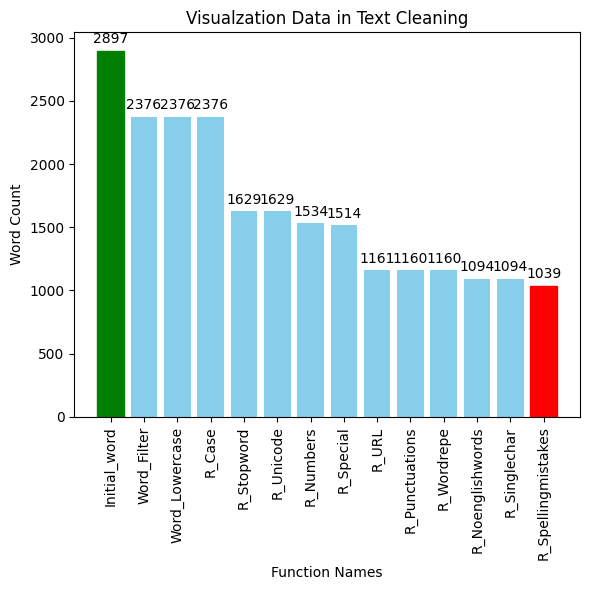


List of EO4GEO BOK concept:
 ['Analytical Methods', 'Foundations of analytical methods', 'Analytical approaches', 'Data mining', 'Problems of large spatial databases', 'Data mining approaches', 'Knowledge discovery', 'Network analysis', 'Networks defined', 'Graph theoretic descriptive measures of networks', 'Least-cost shortest path', 'Flow modeling', 'The Classic Transportation Problem', 'Other classic network problems', 'Accessibility modeling', 'Optimization and location-allocation modeling', 'Operations research modeling and location modeling principles', 'Linear programming', 'Integer programming', 'Location-allocation modeling and p-median problems', 'Representation transformation', 'Impacts of transformations', 'Data model and format conversion', 'Interpolation', 'Vector-to-raster and raster-to-vector conversions', 'Raster resampling', 'Coordinate transformations', 'Generalization and aggregation', 'Scale and generalization', 'Approaches to point, line, and area generalization'

In [1]:
# IMPORT REQUIRD LIBRARIES 

import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import enchant
import json
import string
import numpy as np
import fitz 
from scipy.spatial.distance import cosine
from PyPDF2 import PdfReader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from keybert import KeyBERT
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# This is the function for automate the annotation PDF resources with EO4GEOBOK concepts

# This function (KEYBERT_LSA) contains main 05 functions
      # a. Text cleaning function --> Text_Cleaner()
      # b. Automatic extracion of list of BOK concept  --> EO4GEO()
      # c. Automatic Key phrases extraction from text given by PDF --> KEYBERT_Extractor()
      # d. Similarity measurement between extracted key phrases and EO4GEO concepts --> LSA_Similarity
      # e. Download output results as a JSON format --> Create_Json()
      
def KEYBERT_LSA(pdf):
      
# 01. FUNCTION FOR TEXT CLEANING  
   
   global corrected_words
   corrected_words = []

   def Text_Cleaner():
   # 1. Function to show metadata of the PDF
      def metaData(pdf):
         reader = PdfReader(pdf)
         meta = reader.metadata
         print("Meta data of the PDF")
         print("Total number of pages in the PDF file is: ", len(reader.pages))
         print("Author name:", meta.author)
         print("Creator name:", meta.creator)
         print("Producer name:", meta.producer)
      metaData(pdf)
   #-----------------------------------------------------------------------------------
   # 2. Remove footers from the text
      def remove_Singlelines(text):
         pattern = r'AGILE: GIScience Series.*?https://doi\.org/[^\s]+'
         matches = re.findall(pattern, text)
         removed_text = ""
         for match in matches:
            removed_text += match + "\n"
            text = text.replace(match, '')
         return removed_text, text.strip()
      
      global http_sections
      http_sections = ""
      
   # 3. Remove headers from the text
      def remove_Agilelicense(text):
         pattern = r'AGILE: GIScience Series.*?This work is distributed under the Creative Commons Attribution 4.0 License'
         match = re.search(pattern, text, flags=re.DOTALL)
         removed_text = ""
         global http_sections
         if match:
            removed_text = match.group(0)
            text = text.replace(removed_text, '')
            http_pattern = re.compile(r'https?://doi\.org/[^\s]+')
            http_matches = re.findall(http_pattern, removed_text)
            http_sections += " ".join(http_matches)
         return removed_text, text.strip(),http_sections

      def extract_Agileinfo(pdf_path):
         doc = fitz.open(pdf_path)
         agile_info = ""
         inagile_section = False

         for page_number in range(doc.page_count):
            page = doc[page_number]
            text = page.get_text("text")
            
            if "AGILE: GIScience Series" in text:
               inagile_section = True
               agile_info += text

            elif inagile_section and "© Author(s)" in text:
               agile_info += text
               inagile_section = False
               break
            
            elif inagile_section:
               agile_info += text

         doc.close()
         return agile_info.strip()

      pdf_path = pdf
      extracted_info = extract_Agileinfo(pdf_path)
      reagile_part, cleanedtext_agile,http_sections = remove_Agilelicense(extracted_info)
      resingle_lines, cleanedtext_all = remove_Singlelines(cleanedtext_agile)
      print("\nRemoved Header:")
      print(reagile_part)
      print("\nRemoved Footers:")
      print(resingle_lines)
      print("\nDOI of the paper:")
      print(http_sections)
   #----------------------------------------------------------------------------------------
   # 4. Remove hyphens within words
      def remove_Hypens(text):
         stringwithout_hyp = text.replace('-', ' ')
         return stringwithout_hyp
      withouthypen = remove_Hypens(cleanedtext_all)
   #--------------------------------------------------------------------------------------
   # 5.Tokenization - split the entire paragraph into words (tokens)
      def token_Words(text):
         list_words = word_tokenize(text)
         return list_words
      split_words = token_Words(withouthypen)
   #---------------------------------------------------------------------------------------
   # 6.Filterd the required portion
      def split_Portion(para):
         index1 = para.index('Abstract')
         index2 = para.index('References')
         filter_potion=para[index1+1:index2]
         return filter_potion
      filter = split_Portion(split_words)
   #-----------------------------------------------------------------------------------------
   # 7.Extract the title ofthe document
      global title
      def title_Ex(word_list):
         index3 = word_list.index('Abstract')
         title = word_list[0:index3]
         separator = ' ' 
         result = separator.join(title) 
         return result
      title = title_Ex(split_words)
   #---------------------------------------------------------------------------------------
   # 8. Convert words in to lowercases
      def lowercase_Words(list):
         lowercase_remain =[]
         for i in list:
            x = i.lower()
            lowercase_remain.append(x)
         return lowercase_remain
      lower_words = lowercase_Words(filter)
   #------------------------------------------------------------------------------------------
   # 9. Remove cases.Remove some words and letters which are not in English language
      def remove_Case(text_remain):
         cleaned_texts =[]
         for text in text_remain:
            text = text.casefold()
            cleaned_texts.append(text)
         return cleaned_texts
      Rem_cases = remove_Case(lower_words)
   #----------------------------------------------------------------------------------------
   # 10. Remove Stop words in English language
      def remove_Stopword(cleaned_texts):
         stop_words = stopwords.words('english')
         stopword_list = []
         nostopword_list = []
         for word in cleaned_texts:
            if word in stop_words:
               stopword_list.append(word)
            elif word not in stop_words:
               nostopword_list.append(word)
         return nostopword_list
      Rem_stopwords = remove_Stopword(Rem_cases) 
   #-----------------------------------------------------------------------------------------
   # 11.Remove unicode symbols from the text
      def remove_Unicode(nostop_word):
         no_unicode = []
         for word in nostop_word:
            cleaned_word = re.sub(r'[^\x00-\x7F]+', '', word)
            no_unicode.append(cleaned_word)
         return no_unicode
      Rem_unicodes = remove_Unicode(Rem_stopwords)
   #-------------------------------------------------------------------------------------------
   # 12. Remove numbers and digits
      def remove_Numbers(nounicode_list):
         no_number_list = []
         number_list = []
         for token in nounicode_list:
            if token.isdigit():
               number_list.append(token)  
            elif token.count('.') == 1 and token.replace('.', '').isdigit():
               number_list.append(token) 
            else:
               no_number_list.append(token) 
         return no_number_list
      Rem_numbers = remove_Numbers(Rem_unicodes) 
   #-------------------------------------------------------------------------------------------
   # 13. Remove special words with having mix of string, numbers, punctuations and other symbols
      def remove_Special(nospecial_list):
         no_sp_words = []
         num_string_list = []
      # Regular expression pattern to match any string containing numeric characters or hyphens
         pattern = r'^(?=.*\d)(?=.*[A-Za-z])|(?=.*[A-Za-z])(?=.*[\W_])|(?=.*\d)(?=.*[\W_])'
         for text in nospecial_list:
            if not re.match(pattern, text):
               no_sp_words.append(text)
            elif re.match(pattern, text):
               num_string_list.append(text) 
         return no_sp_words
      Rem_special = remove_Special(Rem_numbers)
   #---------------------------------------------------------------------------------------
   # 14. remove URL, @
      def remove_Repeat(nosp_words):
         list1 = []
         list2 = []
         text1 = r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
         for i in nosp_words:
            if not re.match(text1, i):
               list1.append(i)
            elif re.match(text1, i):
               list2.append(i)
         return list1
      Rem_url = remove_Repeat(Rem_special)
   #---------------------------------------------------------------------------------------
   # 15.Remove punctuations from the list
      def remove_Punc(cleaned_words):
         punctuation_marks=[]
         without_punct_marks=[]
         for token in cleaned_words:
            if token in ("!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"):
               punctuation_marks.append(token)
            elif token not in ("!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"):
               without_punct_marks.append(token)
         return without_punct_marks
      Rem_punc = remove_Punc(Rem_url)
   #----------------------------------------------------------------------------------------
   # 16. Remove word repetition
      def word_Repeti(list):
         pattern = re.compile(r'\b\w*(\w)\1{3,}\w*\b')
         filtered_word_list =[]
         for word in list:
            if not pattern.search(word):
               filtered_word_list.append(word)
         return filtered_word_list
      Rem_repeat = word_Repeti(Rem_punc)
   #------------------------------------------------------------------------------------------
   # 17.Remove single characters and non-English words  
      def rem_Noenglish(filtered_word):
         english_words = set(words.words())
         filtered_words = []
         for word in filtered_word:
            if len(word) > 4: 
               filtered_words.append(word)
            elif word.lower() in english_words:
               filtered_words.append(word)
            else:
               continue
         return filtered_words
      Rem_noenglish = rem_Noenglish(Rem_repeat)
   #-------------------------------------------------------------------------------------------
   # 18. Remove single-character 
      def remsingle_Words(word_list):
         new_list = []
         other = []
         for word in word_list:
            if len(word) > 1:
               new_list.append(word)
            else:
               other.append(word)
         return new_list
      Rem_single = remsingle_Words(Rem_noenglish)
   #-----------------------------------------------------------------------------------------
   # 19. Remove words with spelling mistakes
      def spelling_Check(word_list):
         spell_checker = enchant.Dict("en")
         global corrected_words 
         for word in word_list:
            if spell_checker.check(word):
               corrected_words.append(word)
         return corrected_words
      corrected_words = spelling_Check(Rem_single )
   #----------------------------------------------------------------------------------------
   # 20. Calculations
      def calculation():
         initial_words = len(split_words)
         total_words = len(filter)
         final_words = len(corrected_words)
         Remain_percentage = (final_words / total_words) * 100
         print("\nTITLE OF THE DOCUMENT \n",title)
         print("\nText Cleaning Results")
         print("Total number of words before split the portion is", initial_words)
         print("Total number of words after split the portion (Abstract to Refrence) is", total_words)
         print("Total number of words after text cleaning is", final_words)
         print("The remaining percentage of the words is", round(Remain_percentage, 2), "%")
      calculation()
   #--------------------------------------------------------------------------------------------
   # 21. Make a data frame for text cleaning steps
      def dataFrame():
         a = len(split_words)
         b = len(filter)
         c = len(lower_words)
         d = len(Rem_cases)
         e = len(Rem_stopwords)
         f = len(Rem_unicodes)
         g = len(Rem_numbers)
         h = len(Rem_special)
         i = len(Rem_url)
         j = len(Rem_punc)
         k = len(Rem_repeat)
         l = len(Rem_noenglish)
         m = len(Rem_single)
         n = len(corrected_words)
    
         function_names = ["Initial_word", "Word_Filter","Word_Lowercase","R_Case", "R_Stopword","R_Unicode", "R_Numbers", "R_Special","R_URL" ,"R_Punctuations","R_Wordrepe","R_Noenglishwords","R_Singlechar","R_Spellingmistakes"]
         word_counts = [a,b,c,d,e,f,g,h,i,j,k,l,m,n]
         df = pd.DataFrame({"Function Name": function_names, "Word Count": word_counts})
         print(df)
         return df
      table = dataFrame()
   #-------------------------------------------------------------------------------------
   # 22. Plot a graph
      def plot_Bargraph(df):
         plt.figure(figsize=(6,6))
         bars = plt.bar(df["Function Name"], df["Word Count"], color='skyblue')
         plt.xlabel('Function Names')
         plt.ylabel('Word Count')
         plt.title('Visualzation Data in Text Cleaning')
         plt.xticks(rotation=90)
      # maximum and minimum values of x values
         max_idx = df["Word Count"].idxmax()
         min_idx = df["Word Count"].idxmin()
      # Highlight the maximum and minimum values 
         bars[max_idx].set_color('green')
         bars[min_idx].set_color('red')
      # Labeling the bars with their respective values
         for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height}',xy=(bar.get_x() + bar.get_width() / 2, height),xytext=(0, 3),  textcoords="offset points",ha='center', va='bottom')
         plt.tight_layout()
         plt.show()
      plot_Bargraph(table)
   Text_Cleaner()
   
#///////////////////////////////////////////////////////////////////////////////////////////////

# 02. FUNCTION FOR AUTOMATE THE EXTRACTION THE LIST OF EO4GEO BOK CONCEPT AND PRE-PROCSEESING THE EXTRACTED LIST
   
   global title
   global cleaned_list
   cleaned_list =[]
   global concept_names
   concept_names = []
   
   def EO4GEO():
   # 1. automatic list of BOK concept extraction using jason file
      with open('Data.json', 'r', encoding='utf-8') as json_file:
         data = json.load(json_file)
      def EO4GEOlist_extractor(data):
      # Open and load the JSON file with UTF-8 encoding
         names = []
         for key, value in data.items():
            if isinstance(value, dict):
               if 'name' in value:
                  names.append(value['name'])
                  names.extend(EO4GEOlist_extractor(value))
         return names
      global concept_names
      concept_names = EO4GEOlist_extractor(data)
      print("\nList of EO4GEO BOK concept:\n", concept_names)
      print("\nLength of the list of EO4GEO BOK \n",len(concept_names))
   #------------------------------------------------------------------------------------------
   # 2. Convert lower case in the words and phrass in the list
      def lower_EO4GEO(list):
         lst = []
         for x in list:
            x = x.lower()
            lst.append(x)
         return lst
      lower_list = lower_EO4GEO(concept_names)
   #----------------------------------------------------------------------------------------
   # 3. Remove stop words from an element
      def remove_Stopwords(element):
         words = element.split()
         filtered_words = []
         for word in words:
            if word.lower() not in stopwords.words('english'):
               filtered_words.append(word)
         return ' '.join(filtered_words)
      
      remove_stop = []
      for element in lower_list:
         cleaned_element = remove_Stopwords(element)
         remove_stop.append(cleaned_element)
   #------------------------------------------------------------------------------------------
   # 4. Remove punctuations for the elements in the list
      def process_Word(word):
         word = word.replace('-', ' ')
         word = word.replace(',', ' ')
         word = word.replace('/', ' ')
         word = word.replace(':', ' ')
         word = word.replace('()', ' ')
         word = word.replace("'", '')
   
         wordnoPunctuation = ""
         for char in word:
            if char not in string.punctuation:
               wordnoPunctuation += char
         return wordnoPunctuation
   
      processed_lst = []
      for word in remove_stop:
         processed_lst.append(process_Word(word))
   #-----------------------------------------------------------------------------------------
   # 5. Remove extra white spaces
      def clean_Strings(list):
         global cleaned_list
         for element in list:
            cleaned_element = ' '.join(element.split())
            cleaned_list.append(cleaned_element)
         return cleaned_list
      clean_Strings(processed_lst)
      print("\nList of EO4GEO BOK concept after doing text cleaning:\n", cleaned_list)
   EO4GEO()
   
   EO4GEOBOK_keyphrases = cleaned_list
   
#///////////////////////////////////////////////////////////////////////////////////////////////

# 03. FUNCTION FOR AUTOMATIC KEY PHRASE EXTRACTION USING KEYBERT ALGORITHM
   global x
   x = print("\nText from PDF after text cleaning \n", corrected_words)
   global Keybert_kp
   Keybert_kp =[]
   KEYBERT_keyphrases =  Keybert_kp
#-----------------------------------------------------------------------------------  
   def KeyBert_extrator(list):
# Convert list in to string
      listToStr = ' '.join(map(str, list))
# Extraction of key phrases using KeyBert algorithom
      kw_model = KeyBERT()
      listkp = kw_model.extract_keywords(listToStr, keyphrase_ngram_range=(1, 4), stop_words=None,top_n=100)
      global  Keybert_kp
      for item in listkp:
          Keybert_kp.append(item[0])
      print("Extracted key phrase using KetBert algorithm \n", Keybert_kp)
      return  Keybert_kp
     
   KeyBert_extrator(corrected_words)
      
#///////////////////////////////////////////////////////////////////////////////////////////////

# 04. FUNCTION FOR LATENT SIMENTIC ANALYSIS SIMILARITY MEASURES
   
   global abovethreshold_phrases
   abovethreshold_phrases = set()
   phrase1_frequency = {}
   
   def LSA_similarity(list1, list2,threshold):
      mappdict_eo4geo = dict(zip(list1, concept_names))
      
      combined_elements = list1 + list2

    # Create a Document-Term Matrix (DTM) 
      vectorizer = CountVectorizer(min_df=1, stop_words='english')
      dtm_combined = vectorizer.fit_transform(combined_elements)

    # Apply TruncatedSVD (LSA) to the combined DTM
      n_components = 2
      lsa = TruncatedSVD(n_components=n_components, algorithm='arpack')
      dtmcombined_lsa = lsa.fit_transform(dtm_combined.astype(float))
      dtmcombined_lsa = Normalizer(copy=False).fit_transform(dtmcombined_lsa)

    # Split the LSA components back into two parts for each list
      dtmlist1_lsa = dtmcombined_lsa[:len(list1)]
      dtmlist2_lsa = dtmcombined_lsa[len(list1):]

    # Compute element-wise similarity using LSA components
      similarity_matrix = np.dot(dtmlist1_lsa, dtmlist2_lsa.T)

    # DataFrame to display the similarity matrix
      df_similarity = pd.DataFrame(similarity_matrix, index=list1, columns=list2)
      df_similarity.to_csv('document_similarity.csv')
    
      print("\nKey Phrases with Similarity > {}:".format(threshold))
      
      similarity_list = []
      countabove_threshold = 0
      for i, phrase1 in enumerate(list1):
         for j, phrase2 in enumerate(list2):
            similarity = similarity_matrix[i, j]
            if similarity > threshold:
               concept_name = mappdict_eo4geo[phrase1]
               similarity_list.append((concept_name, phrase2, similarity))
               countabove_threshold += 1
               abovethreshold_phrases.add(concept_name)
               phrase1_frequency[concept_name] = phrase1_frequency.get(concept_name, 0) + 1
      
      #arrange in to the descending order
      similarity_list.sort(key=lambda x: x[2], reverse=True)
      for concept_name, phrase2, similarity in similarity_list:
        print(f"Similarity between '{concept_name}' and '{phrase2}' : {similarity}")
      
      print("\nElement-wise Similarity:")
      print(df_similarity)
      print(f"Total similarity measures above the threshold: {countabove_threshold}")
      print(abovethreshold_phrases)
      print("\nTotal number of EO4GEO BOK concepts match to given pdf:\n",len(abovethreshold_phrases))
      print("\nFrequency of each EO4GEO BOK concepts above the threshold:")
      for concept_name, frequency in phrase1_frequency.items():
         print(f"{concept_name}: {frequency}")
      
   list1 = EO4GEOBOK_keyphrases
   list2 = KEYBERT_keyphrases

   LSA_similarity(list1, list2, threshold=0.9)
#///////////////////////////////////////////////////////////////////////////////////////////////

# 05. FUNCTION FOR CREATE JSON FILE TO DOWNLOAD FINAL OUTPUTS GIVEN BY PROPOSED TOOL

   def Create_Json(doi, title,concepts):
      output_data = {
        "DOI": doi,
        "Title": title,
        "Concepts": list(concepts)
      }

      json_filename = "JSON_KEYBERTLSA.json"

      with open(json_filename, 'w') as json_file:
         json.dump(output_data, json_file, indent=4)

   DOI = http_sections
   TITLE =title
   CONCEPTS =  abovethreshold_phrases

   Create_Json(DOI, TITLE, CONCEPTS)

KEYBERT_LSA('Augustijn-FULL_feedback.pdf')

